### Урок 4. Деревья решений

## Практическое задание

In [78]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection

import numpy as np

In [79]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [80]:
x = X[2,:]
print(x)
print(y)
print(x >= 1000)
print(y[x >= 1000])
right_1 = (y[x >= 1000] == 0)
right_2 = (y[x >= 1000] == 1)
print('Нулей:', right_1.sum(), 'единиц:', right_2.sum())

[ 500.  700.  750.  600. 1450.  800. 1500. 2000.  450. 1000.]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
[False False False False  True False  True  True False  True]
[1. 1. 0. 1.]
Нулей: 1 единиц: 3


In [81]:
def calc_gini(x, y, t):
    qty_all = len(y)
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    # Индекс Джини не будет равен бесконечности в таком случае,
    # но и считать его особо смысла нет, так как получается только одна ветвь
    if qty_left == 0 or qty_right == 0:
        return np.inf

    qty0_left = ((y[x < t]) == 0).sum()
    qty0_right = ((y[x >= t]) == 0).sum()

    p0_left = qty0_left / qty_left
    p1_left = 1 - p0_left

    p0_right = qty0_right / qty_right
    p1_right = 1 - p0_right

    # Нормировочный коэффициент для левого листа
    left_coef = qty_left / qty_all

    # Индекс Джини для левого листа
    h_left = p0_left * (1 - p0_left) + p1_left * (1 - p1_left)
    # Индекс Джини для правого листа
    h_right = p0_right * (1 - p0_right) + p1_right * (1 - p1_right)

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

In [82]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity, classes

In [83]:
print(y[x >= 1000])
i, c = gini(y[x >= 1000])
print(i, c)

print(y[x < 1000])
i, c = gini(y[x < 1000])
print(i, c)

[1. 1. 0. 1.]
0.375 {1.0: 3, 0.0: 1}
[0. 0. 1. 0. 0. 1.]
0.4444444444444445 {0.0: 4, 1.0: 2}


In [84]:
# Расчёт прироста качества при разбиении вершины дерева

def quality_0(left_labels, right_labels):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    gini_left, _ = gini(left_labels)
    gini_right, _ = gini(right_labels)
    
    return p * gini_left + (1 - p) * gini_right

In [85]:
for t in x:
    print('Порог: {}, gini = {} ({})'.format(t, calc_gini(x, y, t), quality_0(y[x < t], y[x >= t])))

Порог: 500.0, gini = 0.4444444444444444 (0.4444444444444444)
Порог: 700.0, gini = 0.47619047619047616 (0.47619047619047616)
Порог: 750.0, gini = 0.4166666666666667 (0.4166666666666667)
Порог: 600.0, gini = 0.5 (0.5)
Порог: 1450.0, gini = 0.47619047619047616 (0.4761904761904763)
Порог: 800.0, gini = 0.48 (0.48)
Порог: 1500.0, gini = 0.5 (0.5)
Порог: 2000.0, gini = 0.4444444444444444 (0.4444444444444444)
Порог: 450.0, gini = inf (0.5)
Порог: 1000.0, gini = 0.4166666666666667 (0.4166666666666667)


1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

In [86]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [87]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его   
        prediction = max(classes, key=classes.get)
        return prediction

In [88]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        impurity -= p ** 2 # Критерий Джини
        
    return impurity

In [89]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [90]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

Добавим критерий останова по достижении заданной **глубины дерева, с регулируемым количеством элементов в листе**:

In [91]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf=None):
    
    if min_leaf is None:
        min_leaf = 1
    else:
        min_leaf = min_leaf

    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        # будем проверять только уникальные значения признака
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [92]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth=None, min_leaf=None):
    
    if max_depth != None:
        max_depth = max_depth
    else:
        max_depth = np.inf

    quality, t, index = find_best_split(data, labels, min_leaf) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0 or max_depth == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth = max_depth - 1, min_leaf = min_leaf)
    false_branch = build_tree(false_data, false_labels, max_depth = max_depth - 1, min_leaf = min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [93]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [94]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [95]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    

In [96]:
data, labels = datasets.make_classification(n_samples=800, n_features=2, n_informative=2, n_classes=2,
                                            n_redundant=0,n_clusters_per_class=1, flip_y=0.75, random_state=5)

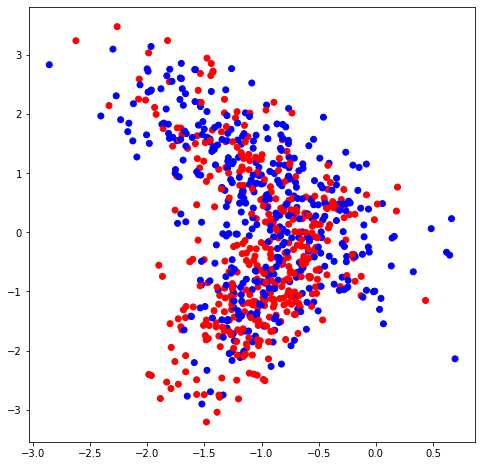

In [97]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), c=labels, cmap=colors)

In [98]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    data, labels, test_size = 0.3, random_state = 1)

In [99]:
my_tree = build_tree(train_data, train_labels, max_depth=4, min_leaf=8)

In [100]:
# print_tree(my_tree)

In [101]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[:5]

[1, 0, 1, 1, 0]

In [102]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [103]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [104]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

66.96428571428571

In [105]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

57.08333333333333

Text(0.5, 1.0, 'Test accuracy=57.08')

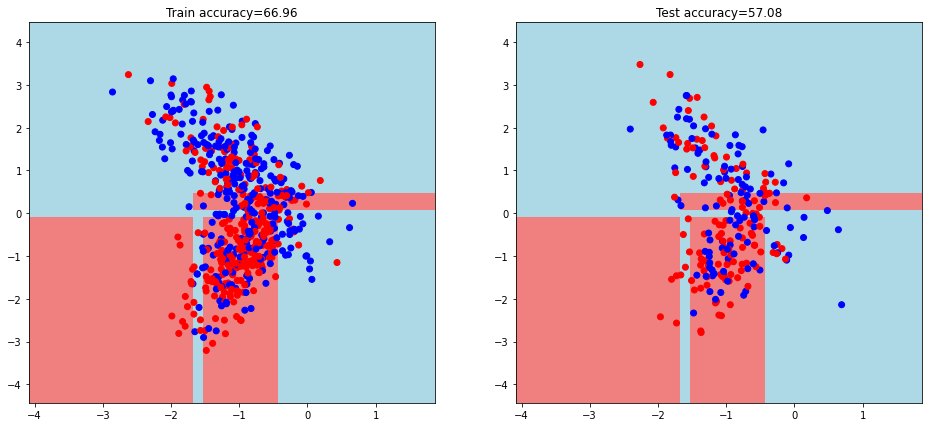

In [106]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [107]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.y_true = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        return np.mean(self.y_true)

In [108]:
def gini(data):
    return np.mean((data - np.mean(data))**2)

In [127]:
# сгенерируем набор данных
data1, target = datasets.make_regression(n_samples=100, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 5, random_state = 2)

In [128]:
train_data, test_data, train_y, test_y = model_selection.train_test_split(data1, target, 
                                                                          test_size = 0.3, random_state = 1)

In [129]:
my_tree = build_tree(train_data, train_y, max_depth=5, min_leaf=3)

In [130]:
print_tree(my_tree)

Индекс 0
Порог -0.32358007007652395
--> True:
  Индекс 0
  Порог -1.4212172273041268
  --> True:
    Индекс 0
    Порог -1.5466746112644163
    --> True:
      Прогноз: -77.275782462658
    --> False:
      Прогноз: -56.38343181431144
  --> False:
    Индекс 1
    Порог -0.5834145945790076
    --> True:
      Индекс 0
      Порог -0.9022460680705018
      --> True:
        Прогноз: -51.020578552600405
      --> False:
        Прогноз: -34.74261318162682
    --> False:
      Индекс 0
      Порог -0.7478709492938624
      --> True:
        Индекс 1
        Порог 0.43309255465669094
        --> True:
          Прогноз: -31.776265246805586
        --> False:
          Прогноз: -20.333695586951436
      --> False:
        Индекс 1
        Порог 0.06648900914614486
        --> True:
          Прогноз: -19.374945048429737
        --> False:
          Прогноз: -5.157374352979395
--> False:
  Индекс 0
  Порог 0.7519648492148806
  --> True:
    Индекс 1
    Порог -0.49817419392175855
    --> Tru

In [131]:
train_y_pred = predict(train_data, my_tree)
train_y_pred[:5]

[-28.553500667323902,
 -31.776265246805586,
 -77.275782462658,
 -20.333695586951436,
 57.48256670841205]

In [132]:
train_y[:5]

array([-23.6587488 , -24.34516712, -87.94080078, -16.31225685,
        76.52414151])

In [133]:
test_y_pred = predict(test_data, my_tree)
test_y_pred[:5]

[17.7932919277114,
 17.7932919277114,
 90.72437211838219,
 -77.275782462658,
 -34.74261318162682]

In [134]:
test_y[:5]

array([ 21.92011473,  17.83857639,  78.03864215, -78.95388881,
       -42.73802094])

In [135]:
def mserror(y, y_pred):
    return (sum((y - y_pred)**2)) / len(y)

In [136]:
print(f'MSE на тренировочной выборке - {round(mserror(train_y, train_y_pred), 2)}\n\
MSE на тестовой выборке - {round(mserror(test_y, test_y_pred), 2)}\n')

MSE на тренировочной выборке - 128.53
MSE на тестовой выборке - 531.32

